# Time Series Analysis

### General Purpose Data Preparation
(See Introduction and Exporatory Data Analysis Notebook)

In [1]:
#Importing libraries and data:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import to dataframe
df = pd.read_csv('hotel_bookings.csv')

#There are two hotels in the data set.
#For increased model accuracy and applicability, I will examine only the Resort Hotel.
df = df[df['hotel'] == 'Resort Hotel']

In [3]:
#Drop rows missing country data.
df = df.dropna(subset=['country'])

#Verify
print(df['country'][df['country'].isna()].head(1))

#Reset index for later dimensionality reduction algorithms.
df = df.reset_index()

Series([], Name: country, dtype: object)


In [4]:
#AGENT: fill missing values with placeholder for self-booking

#Decide on placeholder value
print('max:', df.agent.max())
print('min:', df.agent.min())

#The placeholder for self-booking will be the max value plus one: 536

#Fill
df['agent'] = df['agent'].fillna(536.0)

#Verify
print(df['agent'].isna().head(1))

#New derived feature
df['self_booked'] = df['agent'] != 536.0

max: 535.0
min: 1.0
0    False
Name: agent, dtype: bool


In [5]:
#COMPANY: fill missing values with placeholder for no company
print('max:', df.company.max())
print('min:', df.company.min())

#There is no company id "1", we can use that as our placeholder

#Fill
df['company'] = df['company'].fillna(5.0)

#Verify
print(df['company'].isna().head(1))

#New derived feature
df['on_business'] = df['company'] != 5.0

max: 543.0
min: 6.0
0    False
Name: company, dtype: bool


## Data Prep for Time Series Analysis

My goal is to create a forecast for net booking demand. To that end, I will examine total (gross) bookings (canceled and not canceled); net bookings (not canceled only); and the cancellation rate.

I also need to change the format of the date information to make it compatible with the ARIMA model.

Finally, as I will be modelling several time series features, I will create some altered dataframes to facilitate that.

#### Cancellation Rate

In [6]:
#I need to calculate a cancellation frequency by date for the time series analysis
wcr_df = pd.DataFrame(df[['is_canceled','arrival_date_year','arrival_date_week_number',]].groupby(['arrival_date_year','arrival_date_week_number'], as_index=False).agg('mean'))
wcr_df = wcr_df.rename(index=str, columns={"is_canceled": "wcr"})
df = pd.merge(df,wcr_df,how='left',on=['arrival_date_year','arrival_date_week_number'])

#### Gross Bookings

In [7]:
df['c'] = 1

In [8]:
raw_df = pd.DataFrame(df[['c','arrival_date_year','arrival_date_week_number']].groupby(['arrival_date_year','arrival_date_week_number'], as_index=False).agg('sum'))
raw_df = raw_df.rename(index=str, columns={'c': "raw_bookings"})
df = pd.merge(df,raw_df,how='left',on=['arrival_date_year','arrival_date_week_number'])

In [9]:
df.raw_bookings = df.raw_bookings.astype(float)

#### Net Bookings

In [10]:
df['d'] = df['is_canceled'] == 0

In [11]:
net_df = pd.DataFrame(df[['d','arrival_date_year','arrival_date_week_number']].groupby(['arrival_date_year','arrival_date_week_number'], as_index=False).agg('sum'))
net_df = net_df.rename(index=str, columns={'d': "net_bookings"})
df = pd.merge(df,net_df,how='left',on=['arrival_date_year','arrival_date_week_number'])

In [12]:
df.net_bookings = df.net_bookings.astype(float)

#### Formatting the dates

In [13]:
from datetime import datetime

In [14]:
df['w_date'] = df.arrival_date_year.astype(str) + ' ' + df.arrival_date_week_number.astype(str) 
df['w_date'] = df['w_date'].apply(lambda x: datetime.strptime(x + ' 0', "%Y %W %w"))

#### Dataframes to facilitate ARIMA modeling

In [15]:
arima_feat_df = df[['w_date','wcr','raw_bookings','net_bookings']]
arima_feat_df = arima_feat_df.drop_duplicates()

In [16]:
arima_train_df = arima_feat_df[arima_feat_df['w_date'] <= '2017-05-31']
arima_test_df = arima_feat_df[arima_feat_df['w_date'] > '2017-05-31']

In [17]:
from statsmodels.tsa.arima_model import ARIMA

## Finding the ordering parameters for ARIMA

#### Difference

The data is already pretty close to static, a difference of 1 goes negative very quickly and may be over-differenced. However, I know from examining the data that there is a slight upward trend year over year. A difference of 1 will be used as the most conservative guess.

Text(0.5, 1.0, 'Raw Bookings PACF')

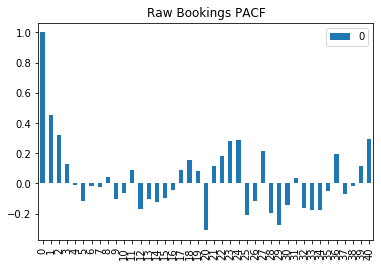

In [18]:
from statsmodels.tsa.stattools import acf, pacf
x_acf = pd.DataFrame(pacf(arima_train_df.raw_bookings))
x_acf.plot(kind='bar')
plt.title("Raw Bookings PACF")

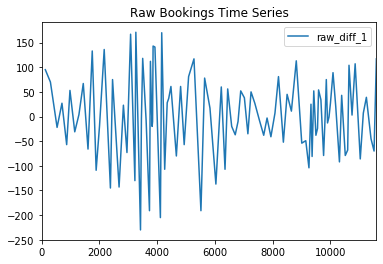

In [19]:
arima_train_df['raw_diff_1'] = arima_train_df.raw_bookings - arima_train_df.raw_bookings.shift()
arima_train_df.plot(y='raw_diff_1')
plt.title('Raw Bookings Time Series')
plt.show()

Text(0.5, 1.0, 'Raw Bookings PACF')

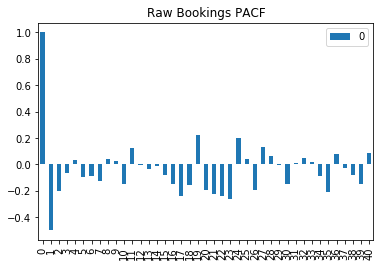

In [20]:
x_acf = pd.DataFrame(pacf(arima_train_df.raw_diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("Raw Bookings PACF")

#### AR and MA Order

Since I have selected a difference order of 1, and the differenced series dispalys a sharp cutoff with a lag-1 autocorrelation that is negative, I will add an MA order of 1 to the model.

# ARIMA models

I tried various parameter configuration for the Gross Bookings model, but all of them produced underwhelming results. Trend lines did not track actual data. However, the models may be of use in a big picture or "macro" kind of way. The best results are discussed in each section.

### Gross Bookings

The model with my intial ordering guess (the 0,1,1 order) did better than 0,1,0 or 1,0,0. 1,1,1 performed on a similar level to 0,1,1. So I decided to try 1,1,2 to keep the benefits (if any) from the AR term and conserve the difference between the AR and MA.

(1,1,2) Did marginally better than the two previous best performers, with a smaller log likelihood, and the only p-value of the set that was greateer than 0.95

In [21]:
from statsmodels.tsa.arima_model import ARIMA as ARIMA2

In [22]:
arima_rb_train_df = arima_train_df[['w_date','raw_bookings']]
arima_rb_train_df = arima_train_df.set_index('w_date')

arima_rb_test_df = arima_test_df[['w_date','raw_bookings']]
arima_rb_test_df = arima_test_df.set_index('w_date')

#### Order: 0, 1, 1

In [23]:
rb_model = ARIMA2(arima_rb_train_df.raw_bookings, order=(0,1,1))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [24]:
rb_model_fit = rb_model.fit()
print(rb_model_fit.summary())
print('Residuals Description')
print(rb_model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:         D.raw_bookings   No. Observations:                  100
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -570.156
Method:                       css-mle   S.D. of innovations             72.277
Date:                Wed, 13 May 2020   AIC                           1146.312
Time:                        18:07:52   BIC                           1154.128
Sample:                             1   HQIC                          1149.475
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.4840      3.022      0.491      0.623      -4.440       7.408
ma.L1.D.raw_bookings    -0.5883      0.084     -6.993      0.000      -0.753      -0.423
            

In [25]:
fc, se, conf = rb_model_fit.forecast(14)

In [26]:
arima_rb_test_df['fc'] = fc

In [27]:
arima_rb_test_df['l_conf'] = conf[:,0]
arima_rb_test_df['u_conf'] = conf[:,1]

In [28]:
arima_rb_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1'], dtype='object')

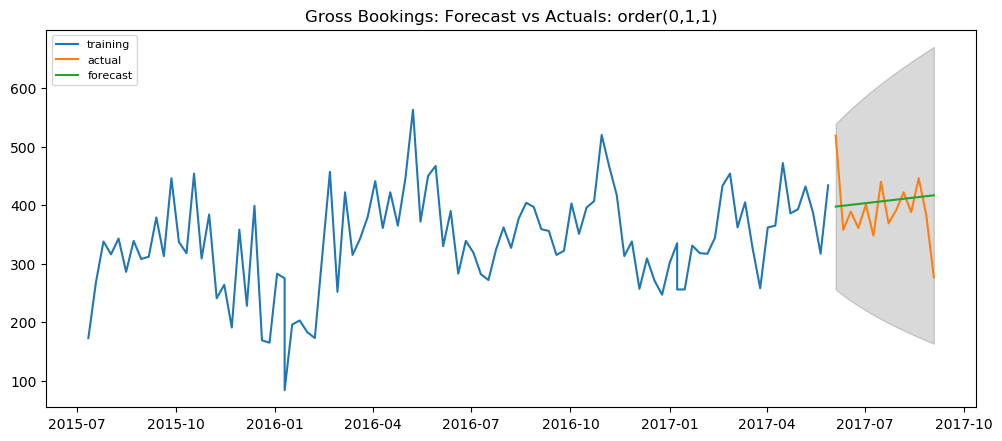

In [29]:
# Forecast
fc, se, conf = rb_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_rb_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_rb_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_rb_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_rb_train_df.raw_bookings, label='training')
plt.plot(arima_rb_test_df.raw_bookings, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Gross Bookings: Forecast vs Actuals: order(0,1,1)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Order: 1,0,0

In [30]:
rb_model = ARIMA2(arima_rb_train_df.raw_bookings, order=(1,0,0))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [31]:
rb_model_fit = rb_model.fit()
print(rb_model_fit.summary())
print('Residuals Description')
print(rb_model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:           raw_bookings   No. Observations:                  101
Model:                     ARMA(1, 0)   Log Likelihood                -577.529
Method:                       css-mle   S.D. of innovations             73.549
Date:                Wed, 13 May 2020   AIC                           1161.058
Time:                        18:07:54   BIC                           1168.904
Sample:                             0   HQIC                          1164.234
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                337.0795     13.627     24.735      0.000     310.370     363.789
ar.L1.raw_bookings     0.4675      0.090      5.192      0.000       0.291       0.644
                    

In [32]:
fc, se, conf = rb_model_fit.forecast(14)

In [33]:
arima_rb_test_df['fc'] = fc

In [34]:
arima_rb_test_df['l_conf'] = conf[:,0]
arima_rb_test_df['u_conf'] = conf[:,1]

In [35]:
arima_rb_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1'], dtype='object')

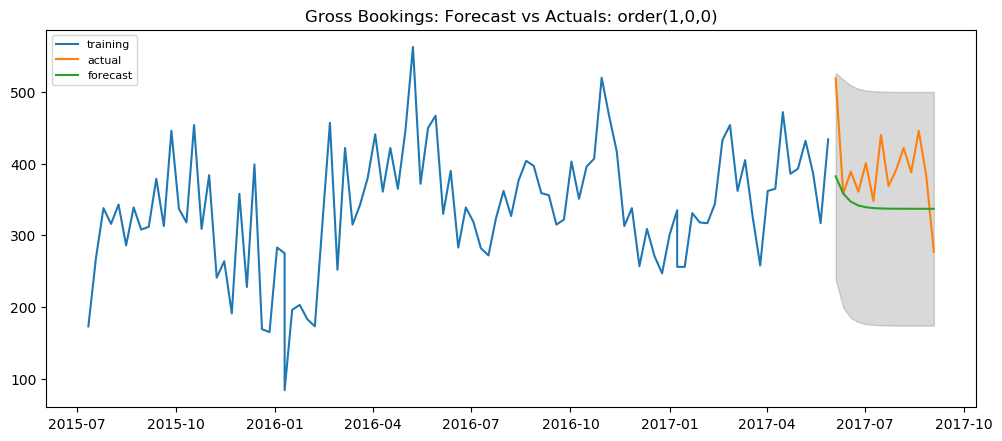

In [36]:
# Forecast
fc, se, conf = rb_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_rb_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_rb_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_rb_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_rb_train_df.raw_bookings, label='training')
plt.plot(arima_rb_test_df.raw_bookings, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Gross Bookings: Forecast vs Actuals: order(1,0,0)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Order: 1,0,1

In [37]:
rb_model = ARIMA2(arima_rb_train_df.raw_bookings, order=(1,0,1))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [38]:
rb_model_fit = rb_model.fit()
print(rb_model_fit.summary())
print('Residuals Description')
print(rb_model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:           raw_bookings   No. Observations:                  101
Model:                     ARMA(1, 1)   Log Likelihood                -572.573
Method:                       css-mle   S.D. of innovations             69.961
Date:                Wed, 13 May 2020   AIC                           1153.145
Time:                        18:07:57   BIC                           1163.606
Sample:                             0   HQIC                          1157.380
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                335.9256     21.292     15.777      0.000     294.195     377.657
ar.L1.raw_bookings     0.8380      0.079     10.546      0.000       0.682       0.994
ma.L1.raw_bookings  

In [39]:
fc, se, conf = rb_model_fit.forecast(14)

In [40]:
arima_rb_test_df['fc'] = fc

In [41]:
arima_rb_test_df['l_conf'] = conf[:,0]
arima_rb_test_df['u_conf'] = conf[:,1]

In [42]:
arima_rb_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1'], dtype='object')

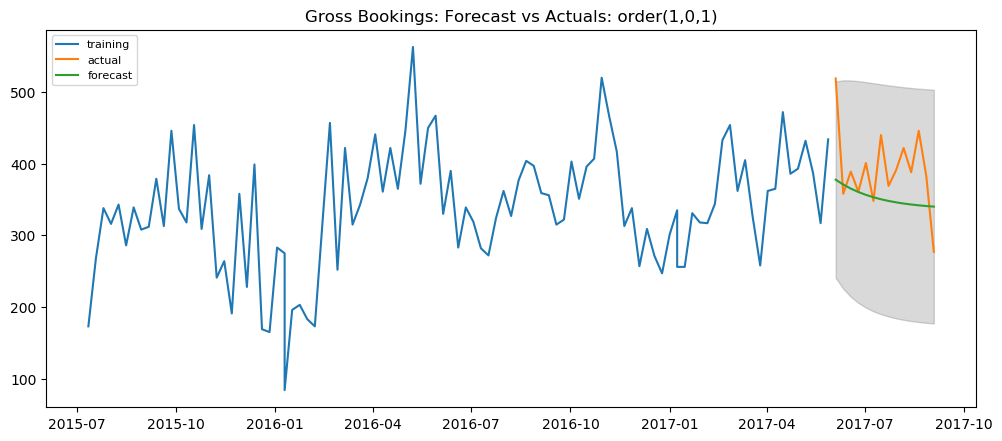

In [43]:
# Forecast
fc, se, conf = rb_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_rb_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_rb_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_rb_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_rb_train_df.raw_bookings, label='training')
plt.plot(arima_rb_test_df.raw_bookings, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Gross Bookings: Forecast vs Actuals: order(1,0,1)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Order: 1,1,1

In [44]:
rb_model = ARIMA2(arima_rb_train_df.raw_bookings, order=(1,1,1))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [45]:
rb_model_fit = rb_model.fit()
print(rb_model_fit.summary())
print('Residuals Description')
print(rb_model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:         D.raw_bookings   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -569.674
Method:                       css-mle   S.D. of innovations             71.932
Date:                Wed, 13 May 2020   AIC                           1147.348
Time:                        18:07:59   BIC                           1157.768
Sample:                             1   HQIC                          1151.565
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.5651      3.423      0.457      0.648      -5.144       8.274
ar.L1.D.raw_bookings    -0.1951      0.187     -1.042      0.297      -0.562       0.172
ma.L1.D.raw_

In [46]:
fc, se, conf = rb_model_fit.forecast(14)

In [47]:
arima_rb_test_df['fc'] = fc

In [48]:
arima_rb_test_df['l_conf'] = conf[:,0]
arima_rb_test_df['u_conf'] = conf[:,1]

In [49]:
arima_rb_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1'], dtype='object')

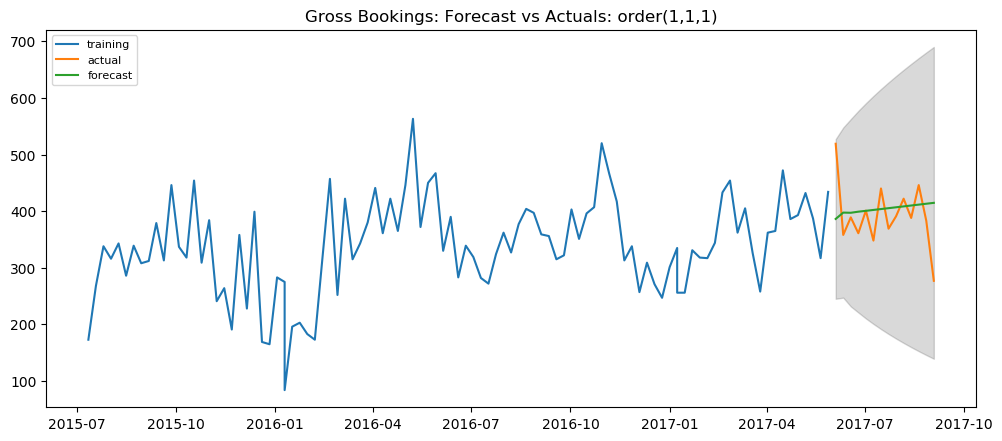

In [50]:
# Forecast
fc, se, conf = rb_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_rb_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_rb_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_rb_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_rb_train_df.raw_bookings, label='training')
plt.plot(arima_rb_test_df.raw_bookings, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Gross Bookings: Forecast vs Actuals: order(1,1,1)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Order: 1,1,2

In [51]:
rb_model = ARIMA2(arima_rb_train_df.raw_bookings, order=(1,1,2))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [52]:
rb_model_fit = rb_model.fit()
print(rb_model_fit.summary())
print('Residuals Description')
print(rb_model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:         D.raw_bookings   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -569.673
Method:                       css-mle   S.D. of innovations             71.932
Date:                Wed, 13 May 2020   AIC                           1149.346
Time:                        18:08:01   BIC                           1162.372
Sample:                             1   HQIC                          1154.618
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.5617      3.406      0.459      0.647      -5.114       8.237
ar.L1.D.raw_bookings    -0.2187      0.684     -0.320      0.749      -1.559       1.121
ma.L1.D.raw_

In [53]:
fc, se, conf = rb_model_fit.forecast(14)

In [54]:
arima_rb_test_df['fc'] = fc

In [55]:
arima_rb_test_df['l_conf'] = conf[:,0]
arima_rb_test_df['u_conf'] = conf[:,1]

In [56]:
arima_rb_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1'], dtype='object')

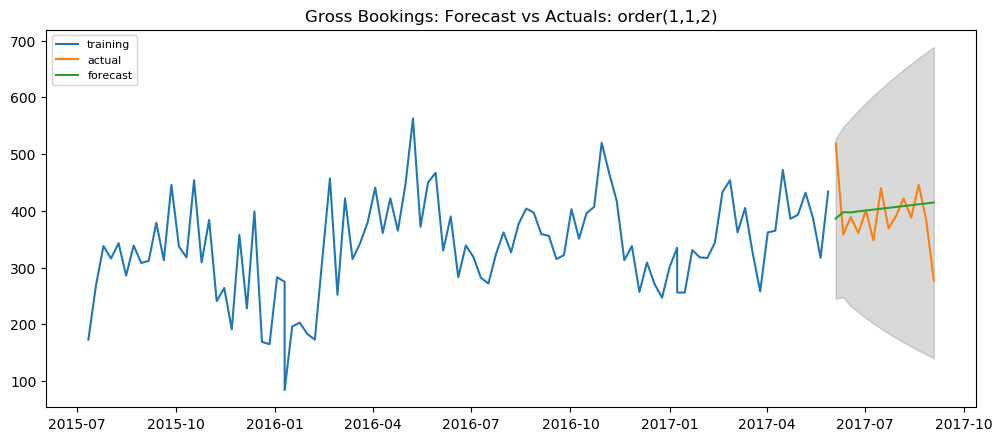

In [57]:
# Forecast
fc, se, conf = rb_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_rb_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_rb_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_rb_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_rb_train_df.raw_bookings, label='training')
plt.plot(arima_rb_test_df.raw_bookings, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Gross Bookings: Forecast vs Actuals: order(1,1,2)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Net Bookings

(1,1,2) ordering was also the best performer for net booking forecasting, with the smallest log likelihood and a p value that approached significance.

In [58]:
from statsmodels.tsa.arima_model import ARIMA as ARIMA3

In [59]:
arima_nb_train_df = arima_train_df[['w_date','net_bookings']]
arima_nb_train_df = arima_train_df.set_index('w_date')

arima_nb_test_df = arima_test_df[['w_date','net_bookings']]
arima_nb_test_df = arima_test_df.set_index('w_date')

In [60]:
nb_model = ARIMA3(arima_nb_train_df.net_bookings, order=(1,1,2))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [61]:
nb_model_fit = nb_model.fit()
print(nb_model_fit.summary())
print('Residuals Description')
print(nb_model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:         D.net_bookings   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -521.669
Method:                       css-mle   S.D. of innovations             44.518
Date:                Wed, 13 May 2020   AIC                           1053.338
Time:                        18:08:04   BIC                           1066.364
Sample:                             1   HQIC                          1058.610
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9628      2.121      0.454      0.650      -3.194       5.120
ar.L1.D.net_bookings     0.1149      1.824      0.063      0.950      -3.461       3.691
ma.L1.D.net_

In [62]:
fc, se, conf = nb_model_fit.forecast(14)

In [63]:
arima_nb_test_df['fc'] = fc

In [64]:
arima_nb_test_df['l_conf'] = conf[:,0]
arima_nb_test_df['u_conf'] = conf[:,1]

In [65]:
arima_nb_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1'], dtype='object')

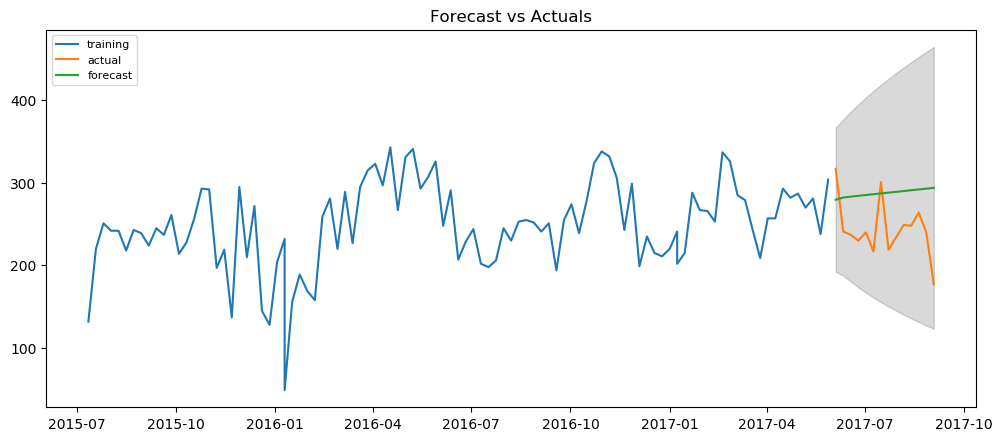

In [66]:
# Forecast
fc, se, conf = nb_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_nb_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_nb_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_nb_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_nb_train_df.net_bookings, label='training')
plt.plot(arima_nb_test_df.net_bookings, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Weekly Cancel Rate

TSA predicated a very nearly constant cancellation rate of 30%. A simple mean cancellation incidence as measured in the Exploratory Data Analysis is 28%. If we take the slope of 0.06 and extrapolate it back over 100 observations, then we would move 6% down to 24%. Since our observed mean cancellation rate was 28%, the models output makes sense.

#### Finding the order

#### Setting up dataframe

Weekly Cancellation rates are a much different beast than raw bookings or net bookings. They require a separate evaulation of model ordering.

In [67]:
arima_wcr_train_df = arima_train_df[['w_date','wcr']]
arima_wcr_train_df = arima_train_df.set_index('w_date')

arima_wcr_test_df = arima_test_df[['w_date','wcr']]
arima_wcr_test_df = arima_test_df.set_index('w_date')

#### Difference, AR, and MA order

One would expect weekly cancellation rate to be static, and the plots show it is . . . on average, however I found that cancellation rates have a seasonal trend, spiking in July. So a difference of 1 was needed to make the best performing model. I found that the best terms for AR and MA were 0.

Text(0.5, 1.0, 'Weekly Cancellation Rate PACF')

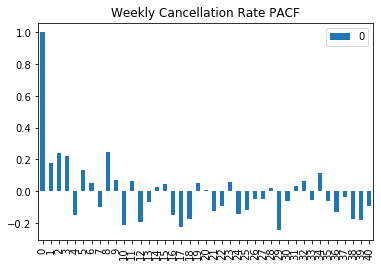

In [68]:
from statsmodels.tsa.stattools import acf, pacf
x_acf = pd.DataFrame(pacf(arima_wcr_train_df.wcr))
x_acf.plot(kind='bar')
plt.title("Weekly Cancellation Rate PACF")

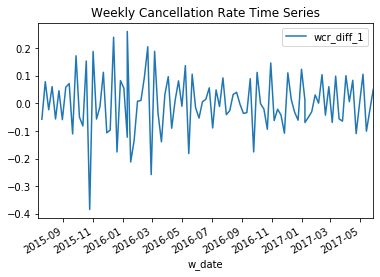

In [69]:
arima_wcr_train_df['wcr_diff_1'] = arima_wcr_train_df.wcr - arima_wcr_train_df.wcr.shift()
arima_wcr_train_df.plot(y='wcr_diff_1')
plt.title('Weekly Cancellation Rate Time Series')
plt.show()

Text(0.5, 1.0, 'Weekly Cancellation Rate PACF')

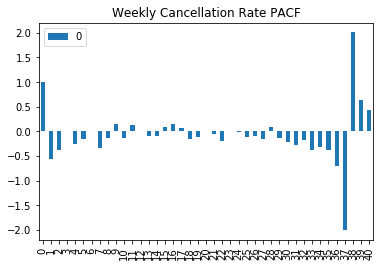

In [70]:
from statsmodels.tsa.stattools import acf, pacf
x_acf = pd.DataFrame(pacf(arima_wcr_train_df.wcr_diff_1[1:]))
x_acf.plot(kind='bar')
plt.title("Weekly Cancellation Rate PACF")

In [71]:
wcr_model = ARIMA(arima_wcr_train_df.wcr, order=(0,1,0))

c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\parke\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [72]:
wcr_model_fit = wcr_model.fit()
print(wcr_model_fit.summary())
print('Residuals Description')
print(wcr_model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                  D.wcr   No. Observations:                  100
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  83.708
Method:                           css   S.D. of innovations              0.105
Date:                Wed, 13 May 2020   AIC                           -163.416
Time:                        18:08:10   BIC                           -158.205
Sample:                             1   HQIC                          -161.307
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.010      0.060      0.952      -0.020       0.021
Residuals Description
count    1.000000e+02
mean     2.082444e-09
std      1.052947e-01
min     -3.849689e-01
25%     -5.883272e-02

In [73]:
fc, se, conf = wcr_model_fit.forecast(14)

In [74]:
arima_wcr_test_df['fc'] = fc

In [75]:
arima_wcr_test_df['l_conf'] = conf[:,0]
arima_wcr_test_df['u_conf'] = conf[:,1]

In [76]:
arima_wcr_train_df.columns

Index(['wcr', 'raw_bookings', 'net_bookings', 'raw_diff_1', 'wcr_diff_1'], dtype='object')

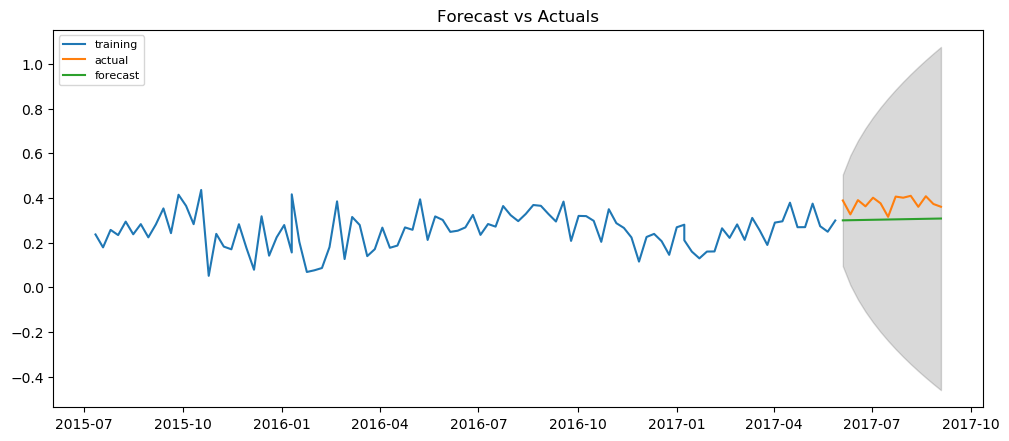

In [77]:
# Forecast
fc, se, conf = wcr_model_fit.forecast(14, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=arima_wcr_test_df.index)
lower_series = pd.Series(conf[:, 0], index=arima_wcr_test_df.index)
upper_series = pd.Series(conf[:, 1], index=arima_wcr_test_df.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_wcr_train_df.wcr, label='training')
plt.plot(arima_wcr_test_df.wcr, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [86]:
arima_feat_df[arima_feat_df['w_date']=='2017-05-28']

,w_date,wcr,raw_bookings,net_bookings
11595,2017-05-28,0.299539,434.0,304.0


## Notebook Summary

In Notebook 2, I did Time Series Analysis for Gross Booking, Net Bookings, and Weekly Cancellation Rate.

I found that for the Bookings, the residuals make it clear that the noise drowns out almost all of the utility that could be derived from the trend lines. However the models can still perhaps be of some value in a "big picture" or macro kind of sense.

For the Weekly Cancellation Rate, the noise is again, mostly overwhelming. Weekly cancellation rate also exhibits seaonal trends. 

For both bookings and cancellation rates, there are probably improvement that could be made with a more sophisticated model such as SARIMA or SES.